#### Notebook setup

In [ ]:
# %pip install -e .

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import time
import warnings
import os, sys
from copy import deepcopy
from types import SimpleNamespace
from pprint import pprint as print

import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm.auto import tqdm, trange

from multirotor.helpers import control_allocation_matrix, DataLog
from multirotor.vehicle import MotorParams, VehicleParams, PropellerParams, SimulationParams, BatteryParams
from multirotor.controller import (
    PosController, VelController,
    AttController, RateController,
    AltController, AltRateController,
    Controller
)
from multirotor.simulation import Multirotor, Propeller, Motor, Battery
from multirotor.coords import body_to_inertial, inertial_to_body, direction_cosine_matrix, euler_to_angular_rate
from multirotor.env import SpeedsMultirotorEnv, DynamicsMultirotorEnv
from multirotor.trajectories import Trajectory
from multirotor.visualize import plot_datalog

In [4]:
import logging

logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True

In [5]:
# Plotting/display parameters
# https://stackoverflow.com/a/21009774/4591810
float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE, titlesize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


### Parameters

In [43]:
# Tarot T18 params
bp = BatteryParams(max_voltage=22.2)
mp = MotorParams(
    moment_of_inertia=5e-5,
    # resistance=0.27,
    resistance=0.081,
    k_emf=0.0265,
    # k_motor=0.0932,
    speed_voltage_scaling= 0.0347,
    max_current=38.
)
pp = PropellerParams(
    moment_of_inertia=1.86e-6,
    use_thrust_constant=True,
    k_thrust=9.8419e-05, # 18-inch propeller
    # k_thrust=5.28847e-05, # 15 inch propeller
    k_drag=1.8503e-06, # 18-inch propeller
    # k_drag=1.34545e-06, # 15-inch propeller
    motor=mp #try motor = none
)
vp = VehicleParams(
    propellers=[pp] * 8,
    battery=bp,
    # angles in 45 deg increments, rotated to align with
    # model setup in gazebo sim (not part of this repo)
    #originally was 0.375
    # angles=np.linspace(0, -2*np.pi, num=8, endpoint=False) + 0.5*np.pi,
    angles=np.array([0.5, 1.5, 0.25, 1.75, 0.75, 1.25, 1, 0])*np.pi,
    distances=np.ones(8) * 0.635,
    # clockwise=[-1,1,-1,1,-1,1,-1,1],
    # clockwise=[1,-1,1,-1,1,-1,1,-1],
    clockwise=[1,1,-1,-1,-1,-1,1,1],
    mass=10.66,
    inertia_matrix=np.asarray([
        [0.2206, 0, 0],
        [0, 0.2206, 0.],
        [0, 0, 0.4238]
    ])
)
sp = SimulationParams(dt=0.01, g=9.81)

### PID Controller

This section explains how a PID controller is constructed. This is a cascaded PID architecture. See `Controller` docs
for more details.

In [7]:
# From PID parameters file
def get_controller(m: Multirotor, max_velocity=5., max_acceleration=3.):
    assert m.simulation.dt <= 0.1, 'Simulation time step too large.'
    pos = PosController(
        1.0, 0., 0., 1., vehicle=m,
        max_velocity=max_velocity, max_acceleration=max_acceleration,
        square_root_scaling=False, leashing=False
    )
    vel = VelController(
        2.0, 1.0, 0.5,
        max_err_i=max_acceleration,
        max_tilt=np.pi/12,
        vehicle=m)
    att = AttController(
        [2.6875, 4.5, 4.5],
        0, 0.,
        max_err_i=1.,
        vehicle=m)
    rat = RateController(
        [4., 4., 4.],
        0, 0,
        max_err_i=0.5,
        max_acceleration=1.,
        vehicle=m)
    alt = AltController(
        1, 0, 0,
        max_err_i=1, vehicle=m,
        max_velocity=max_velocity)
    alt_rate = AltRateController(
        5, 0, 0,
        max_err_i=1, vehicle=m)
    ctrl = Controller(
        pos, vel, att, rat, alt, alt_rate,
        period_p=0.1, period_a=0.01, period_z=0.1
    )
    return ctrl

### Simulation

Combining `Multiotor` and `Controller` to run a simulation. First, defining waypoints:

In [8]:
# NASA flight test
# wp = np.asarray([
#     [0.0, 0.0, 30.0],
#     [164.0146725649829, -0.019177722744643688, 30.0],
#     [165.6418055187678, 111.5351051245816, 30.0],
#     [127.3337449710234, 165.73576059611514, 30.0],
#     [-187.28170707810204, 170.33217775914818, 45.0],
#     [-192.03130502498243, 106.30660058604553, 45.0],
#     [115.89920266153058, 100.8644210617058, 30.0],
#     [114.81859536317643, 26.80923518165946, 30.0],
#     [-21.459931490011513, 32.60508110653609, 30.0]
# ])
# wp = np.asarray([
#     [0,10,0],
#     [10,10,0],
#     [10,0,0],
#     [0,0,0]
# ])
wp = np.asarray([
    [0, 0, 0],
    [0, 5, 13]
])

In [9]:
# Defining the run simulation function which illustrates all the
# steps that go into each step of the simulation.
# 
def run_sim(env, traj, ctrl, steps=60_000, disturbance=None):

    log = DataLog(env.vehicle, ctrl,
                  other_vars=('currents', 'voltages'))

    disturb_force, disturb_torque = 0., 0
    for i, (pos, feed_forward_vel) in tqdm(
        enumerate(traj), leave=False, total=steps
    ):
        if i==steps: break
        # Generate reference for controller
        ref = np.asarray([*pos, 0.])
        # Get prescribed dynamics for system as thrust and torques
        dynamics = ctrl.step(ref, feed_forward_velocity=feed_forward_vel)
        thrust, torques = dynamics[0], dynamics[1:]
        # Allocate control: Convert dynamics into motor rad/s
        action = env.vehicle.allocate_control(thrust, torques)
        # get any disturbances
        if disturbance is not None:
            disturb_force, disturb_torque = disturbance(i, env.vehicle)
        # Send speeds to environment
        state, *_ = env.step(
            action, disturb_forces=disturb_force, disturb_torques=disturb_torque
        )
        alloc_errs = np.asarray([thrust, *torques]) - env.vehicle.alloc @ action**2

        log.log(currents=[p.motor.current for p in env.vehicle.propellers],
                voltages=[p.motor.voltage for p in env.vehicle.propellers])

        if np.any(np.abs(env.vehicle.orientation[:2]) > np.pi/6): break

    log.done_logging()
    return log

In [ ]:
env = SpeedsMultirotorEnv(vehicle=Multirotor(vp, sp)) # step() takes speed signals
traj = Trajectory(env.vehicle, wp, proximity=2, resolution=10)
ctrl = get_controller(env.vehicle, max_velocity=3.)
env.reset()
ctrl.reset()
log = run_sim(env, traj, ctrl, steps=60_000, disturbance=None)

In [ ]:
# PLot positions, velocities, prescribed dynamics
plot_datalog(log)

In [ ]:
# 3D plot of trajectory
# %matplotlib notebook
fig = plt.figure()
xlim = ylim = zlim = (np.min(log.position), np.max(log.position))
ax = fig.add_subplot(projection='3d', xlim=xlim, ylim=ylim, zlim=zlim)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.plot(log.x, log.y, log.z)

### Logging and Plotting

In [10]:
def clear_file(file_path):
    with open(file_path, 'w') as file:
        pass

In [11]:
def logToFile(string_to_log, file_path):
    with open(file_path, 'a') as file:
        file.write(string_to_log + '\n')

In [12]:
def printLog(log, title):
    element_data = {}

    first_key = next(iter(log))
    for index in range(len(log[first_key])):
        element_data[index] = [data[index] for data in log.values()]

    plt.figure(figsize=(12, 4))

    # Plot the data for each element
    for index, data in element_data.items():
        plt.plot(list(log.keys()), data, label=f"Motor {index+1}")

    # Set plot labels and title
    plt.xlabel("Frames")
    plt.ylabel("Motor command")
    plt.title(title)

    # Add legend
    plt.legend(loc='upper left', fontsize='small')

    # Display the plot
    plt.show()

In [13]:
def printLogNonZero(log, title, floor=0):
    element_data = {}

    first_key = next(iter(log))
    for index in range(len(log[first_key])):
        x_values = []
        y_values = []
        for key, data in log.items():
            if data[index] != 0 and key > floor:
                x_values.append(key)
                y_values.append(data[index])
        element_data[index] = (x_values, y_values)

    plt.figure(figsize=(12, 4))

    # Plot the data for each element
    for index, (x_values, y_values) in element_data.items():
        plt.plot(x_values, y_values, label=f"Motor {index+1}")

    # Set plot labels and title
    plt.xlabel("Frames")
    plt.ylabel("Motor command")
    plt.title(title)

    # Add legend
    plt.legend(loc='upper left', fontsize='small')

    # Display the plot
    plt.show()


In [14]:
def printLogNonZeroOverlay(log1, log2, title, floor=0):
    element_data1 = {}
    element_data2 = {}

    first_key1 = next(iter(log1))
    for index in range(len(log1[first_key1])):
        x_values1 = []
        y_values1 = []
        for key, data in log1.items():
            if data[index] != 0 and key > floor:
                x_values1.append(key)
                y_values1.append(data[index])
        element_data1[index] = (x_values1, y_values1)

    first_key2 = next(iter(log2))
    for index in range(len(log2[first_key2])):
        x_values2 = []
        y_values2 = []
        for key, data in log2.items():
            if data[index] != 0 and key > floor:
                x_values2.append(key)
                y_values2.append(data[index])
        element_data2[index] = (x_values2, y_values2)

    plt.figure(figsize=(12, 4))

    # Plot the data for each element in log1
    for index, (x_values, y_values) in element_data1.items():
        plt.plot(x_values, y_values, label=f"Motor {index+1} (AP)")

    # Plot the data for each element in log2 with dotted line style
    for index, (x_values, y_values) in element_data2.items():
        plt.plot(x_values, y_values, '--', label=f"Motor {index+1} (SIM)")

    # Set plot labels and title
    plt.xlabel("Frames")
    plt.ylabel("Motor command")
    plt.title(title)

    # Add legend
    plt.legend(loc='upper left', fontsize=6)

    # Display the plot
    plt.show()


### AP Simulation

In [15]:
import socket
import time
import json
import struct
from multirotor.coords import direction_cosine_matrix, body_to_inertial 

In [52]:
def changeToJSONString(curr_time, state, accel):
    phys_time = curr_time
    pos = state[0:3].tolist()
    velo = state[3:6]
    euler = state[6:9].tolist()
    gyro = state[9:12].tolist()
    accel = accel.tolist()
    
    # gyro[2] = 0

    gyro[0], gyro[1] = gyro[1], gyro[0]
    euler[0], euler[1] = euler[1], euler[0]

    #TODO: Change to NED coordinates
    pos[2] = -1*pos[2]
    pos[0], pos[1] = pos[1], pos[0]

    dcm = direction_cosine_matrix(*euler)
    v_inertial = body_to_inertial(velo, dcm).tolist()
    v_inertial[2] = -1*v_inertial[2]
    v_inertial[0], v_inertial[1] = v_inertial[1], v_inertial[0]

    # Build JSON format
    IMU_fmt = {
        "gyro" : gyro,
        "accel_body" : accel
    }
    JSON_fmt = {
        "timestamp" : phys_time,
        "imu" : IMU_fmt,
        "position" : pos,
        "attitude" : euler,
        "velocity" : v_inertial
    }

    JSON_string = "\n" + json.dumps(JSON_fmt,separators=(',', ':')) + "\n"

    logToFile(json.dumps(JSON_fmt,separators=(',', ':')), "JSONLog.txt")

    return JSON_string


In [17]:
def ap_sim(env, sock, ctrl, traj, steps=60_000, disturbance=None):
    start = 1000000
    ap_log = DataLog(env.vehicle, other_vars=("propeller_speed",))
    command_logger = {}
    sim_command_logger = {}
    
    disturb_force, disturb_torque = 0., 0

    curr_time = 0  # Get the current time in seconds
    RATE_HZ = 100
    TIME_STEP = 1/RATE_HZ
    last_frame = -1
    frame_count = 0
    frame_time = time.time()
    print_frame_count = 500
    try:
        for i, (pos, feed_forward_vel) in tqdm(enumerate(traj), leave=False, total=steps):
            try:   
                data, addr = sock.recvfrom(100)

                parse_format = 'HHI16H'
                magic = 18458

                if len(data) != struct.calcsize(parse_format):
                    print("got packet of len %u, expected %u" % (len(data), struct.calcsize(parse_format)))
                    continue
                unpacked_data = struct.unpack(parse_format, data)

                if magic != unpacked_data[0]:
                    print("Incorrect protocol magic %u should be %u" % (unpacked_data[0], magic))
                    continue

                frame_rate = unpacked_data[1]
                frame_count = unpacked_data[2]
                pwm = np.array(unpacked_data[3:11])

                string_action = " ".join(str(element) for element in pwm.tolist())
                logToFile(string_action, "pwmLog.txt")

                if frame_count < last_frame:
                    print('Reset controller')
                elif frame_count == last_frame:
                    print('Duplicate frame')
                    continue
                if frame_count != last_frame + 1 and last_frame != 0:
                    print("Missed %u frames" % (frame_count - last_frame))
                    continue
                last_frame = frame_count
                
                curr_time += TIME_STEP

                if disturbance is not None:
                    disturb_force, disturb_torque = disturbance(i, env.vehicle)

                action = (pwm-1000)*0.575 # TODO: turn pwm to action
                string_action = " ".join(str(element) for element in action.tolist())
                logToFile(string_action, "actionLog.txt")

                ref = np.asarray([*pos, 0.])
                # Get prescribed dynamics for system as thrust and torques
                dynamics = ctrl.step(ref, feed_forward_velocity=feed_forward_vel)
                thrust, torques = dynamics[0], dynamics[1:]
                # Allocate control: Convert dynamics into motor rad/s
                sim_action = env.vehicle.allocate_control(thrust, torques)
                string_action = " ".join(str(element) for element in sim_action.tolist())
                logToFile(string_action, "simLog.txt")
                sim_command_logger[i] = sim_action.tolist()

                state, *_ = env.step(
                    sim_action, disturb_forces=disturb_force, disturb_torques=disturb_torque
                )
                accel = env.vehicle.dxdt_speeds(0, state, action, disturb_forces=disturb_force, disturb_torques=disturb_torque)[3:6]
                JSON_string = changeToJSONString(curr_time, state, accel)
                # Send to AP
                sock.sendto(bytes(JSON_string,"ascii"), addr)
                
                if action[0] != 0:
                    start = min(start, i)
                    ap_log.log(propeller_speed=[p.state for p in env.vehicle.propellers])
                command_logger[i] = action.tolist()

                # Track frame rate
                if frame_count % print_frame_count == 0:
                    now = time.time()
                    total_time = now - frame_time
                    logToFile("%.2f fps T=%.3f dt=%.3f frame=%.1f rate=%d" % (print_frame_count/total_time, curr_time, total_time, frame_count, RATE_HZ), "frameLog.txt")
                    frame_time = now
            except json.JSONDecodeError:
                print("Invalid JSON data received")
            except socket.timeout:
                continue
            except KeyboardInterrupt:
                sock.close()
            except Exception as e:
                if not isinstance(e, OSError):
                    raise e
                sock.close()
                break
    finally:
        sock.close()
    
    ap_log.done_logging()   
    
    return ap_log, command_logger, sim_command_logger, start


In [28]:
def ap_sim2(env, sock, ctrl, traj, steps=60_000, disturbance=None):
    start = 1000000
    ap_log = DataLog(env.vehicle, other_vars=("propeller_speed",))
    command_logger = {}
    sim_command_logger = {}
    
    disturb_force, disturb_torque = 0., 0

    curr_time = 0  # Get the current time in seconds
    RATE_HZ = 100
    TIME_STEP = 1/RATE_HZ
    last_frame = -1
    frame_count = 0
    frame_time = time.time()
    print_frame_count = 500
    try:
        for i in range(steps):
            try:   
                data, addr = sock.recvfrom(100)

                parse_format = 'HHI16H'
                magic = 18458

                if len(data) != struct.calcsize(parse_format):
                    print("got packet of len %u, expected %u" % (len(data), struct.calcsize(parse_format)))
                    continue
                unpacked_data = struct.unpack(parse_format, data)

                if magic != unpacked_data[0]:
                    print("Incorrect protocol magic %u should be %u" % (unpacked_data[0], magic))
                    continue

                frame_rate = unpacked_data[1]
                frame_count = unpacked_data[2]
                pwm = np.array(unpacked_data[3:11])

                if pwm[0] > 1150:
                    print("takeoff started")
                    break
                    
                curr_time += TIME_STEP
                JSON_string = changeToJSONString(curr_time, np.zeros(12), np.array([0, 0, -9.81]))
                # Send to AP
                sock.sendto(bytes(JSON_string,"ascii"), addr)
            except json.JSONDecodeError:
                print("Invalid JSON data received")
            except socket.timeout:
                continue
            except KeyboardInterrupt:
                sock.close()
            except Exception as e:
                if not isinstance(e, OSError):
                    raise e
                sock.close()
                break
        for i, (pos, feed_forward_vel) in tqdm(enumerate(traj), leave=False, total=steps):
            try:   
                data, addr = sock.recvfrom(100)

                parse_format = 'HHI16H'
                magic = 18458

                if len(data) != struct.calcsize(parse_format):
                    print("got packet of len %u, expected %u" % (len(data), struct.calcsize(parse_format)))
                    continue
                unpacked_data = struct.unpack(parse_format, data)

                if magic != unpacked_data[0]:
                    print("Incorrect protocol magic %u should be %u" % (unpacked_data[0], magic))
                    continue

                frame_rate = unpacked_data[1]
                frame_count = unpacked_data[2]
                pwm = np.array(unpacked_data[3:11])

                string_action = " ".join(str(element) for element in pwm.tolist())
                logToFile(string_action, "pwmLog.txt")

                if frame_count < last_frame:
                    print('Reset controller')
                elif frame_count == last_frame:
                    print('Duplicate frame')
                    continue
                
                last_frame = frame_count
                
                curr_time += TIME_STEP

                if disturbance is not None:
                    disturb_force, disturb_torque = disturbance(i, env.vehicle)

                action = (pwm-1000)*0.575 # TODO: turn pwm to action
                string_action = " ".join(str(element) for element in action.tolist())
                logToFile(string_action, "actionLog.txt")

                ref = np.asarray([*pos, 0.])
                # Get prescribed dynamics for system as thrust and torques
                dynamics = ctrl.step(ref, feed_forward_velocity=feed_forward_vel)
                thrust, torques = dynamics[0], dynamics[1:]
                # Allocate control: Convert dynamics into motor rad/s
                sim_action = env.vehicle.allocate_control(thrust, torques)
                string_action = " ".join(str(element) for element in sim_action.tolist())
                logToFile(string_action, "simLog.txt")
                sim_command_logger[i] = sim_action.tolist()

                state, *_ = env.step(
                    action, disturb_forces=disturb_force, disturb_torques=disturb_torque
                )
                accel = env.vehicle.dxdt_speeds(0, state, action, disturb_forces=disturb_force, disturb_torques=disturb_torque)[3:6]
                JSON_string = changeToJSONString(curr_time, state, accel)
                # Send to AP
                sock.sendto(bytes(JSON_string,"ascii"), addr)
                
                if action[0] != 0:
                    start = min(start, i)
                    ap_log.log(propeller_speed=[p.state for p in env.vehicle.propellers])
                command_logger[i] = action.tolist()

                # Track frame rate
                if frame_count % print_frame_count == 0:
                    now = time.time()
                    total_time = now - frame_time
                    logToFile("%.2f fps T=%.3f dt=%.3f frame=%.1f rate=%d" % (print_frame_count/total_time, curr_time, total_time, frame_count, RATE_HZ), "frameLog.txt")
                    frame_time = now
            except json.JSONDecodeError:
                print("Invalid JSON data received")
            except socket.timeout:
                continue
            except KeyboardInterrupt:
                sock.close()
            except Exception as e:
                if not isinstance(e, OSError):
                    raise e
                sock.close()
                break
    finally:
        sock.close()
    
    ap_log.done_logging()   
    
    return ap_log, command_logger, sim_command_logger, start


In [53]:

UDP_IP = "127.0.0.1"  # Listen on all available interfaces
UDP_PORT = 9002

sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
sock.bind((UDP_IP, UDP_PORT))
sock.settimeout(0.1)  # Set a timeout value of 1 second on the socket object

clear_file("frameLog.txt")
clear_file("JSONLog.txt")
clear_file("pwmLog.txt")
clear_file("simLog.txt")

env = SpeedsMultirotorEnv(vehicle=Multirotor(vp, sp)) # step() takes speed signals
ctrl = get_controller(env.vehicle, max_velocity=3.)
traj = Trajectory(env.vehicle, wp, proximity=0.5, resolution=10)

env.reset(np.zeros(12))
ctrl.reset()
ap_log, action_log, sim_action_log, start = ap_sim2(env, sock, ctrl, traj, steps=60_000, disturbance=None)

sock.close()


'takeoff started'


  0%|          | 0/60000 [00:00<?, ?it/s]

{'pos': <Axes: title={'center': 'Position and Orientation'}, ylabel='Orientation /deg'>,
 'vel': <Axes: title={'center': 'Velocities'}>}

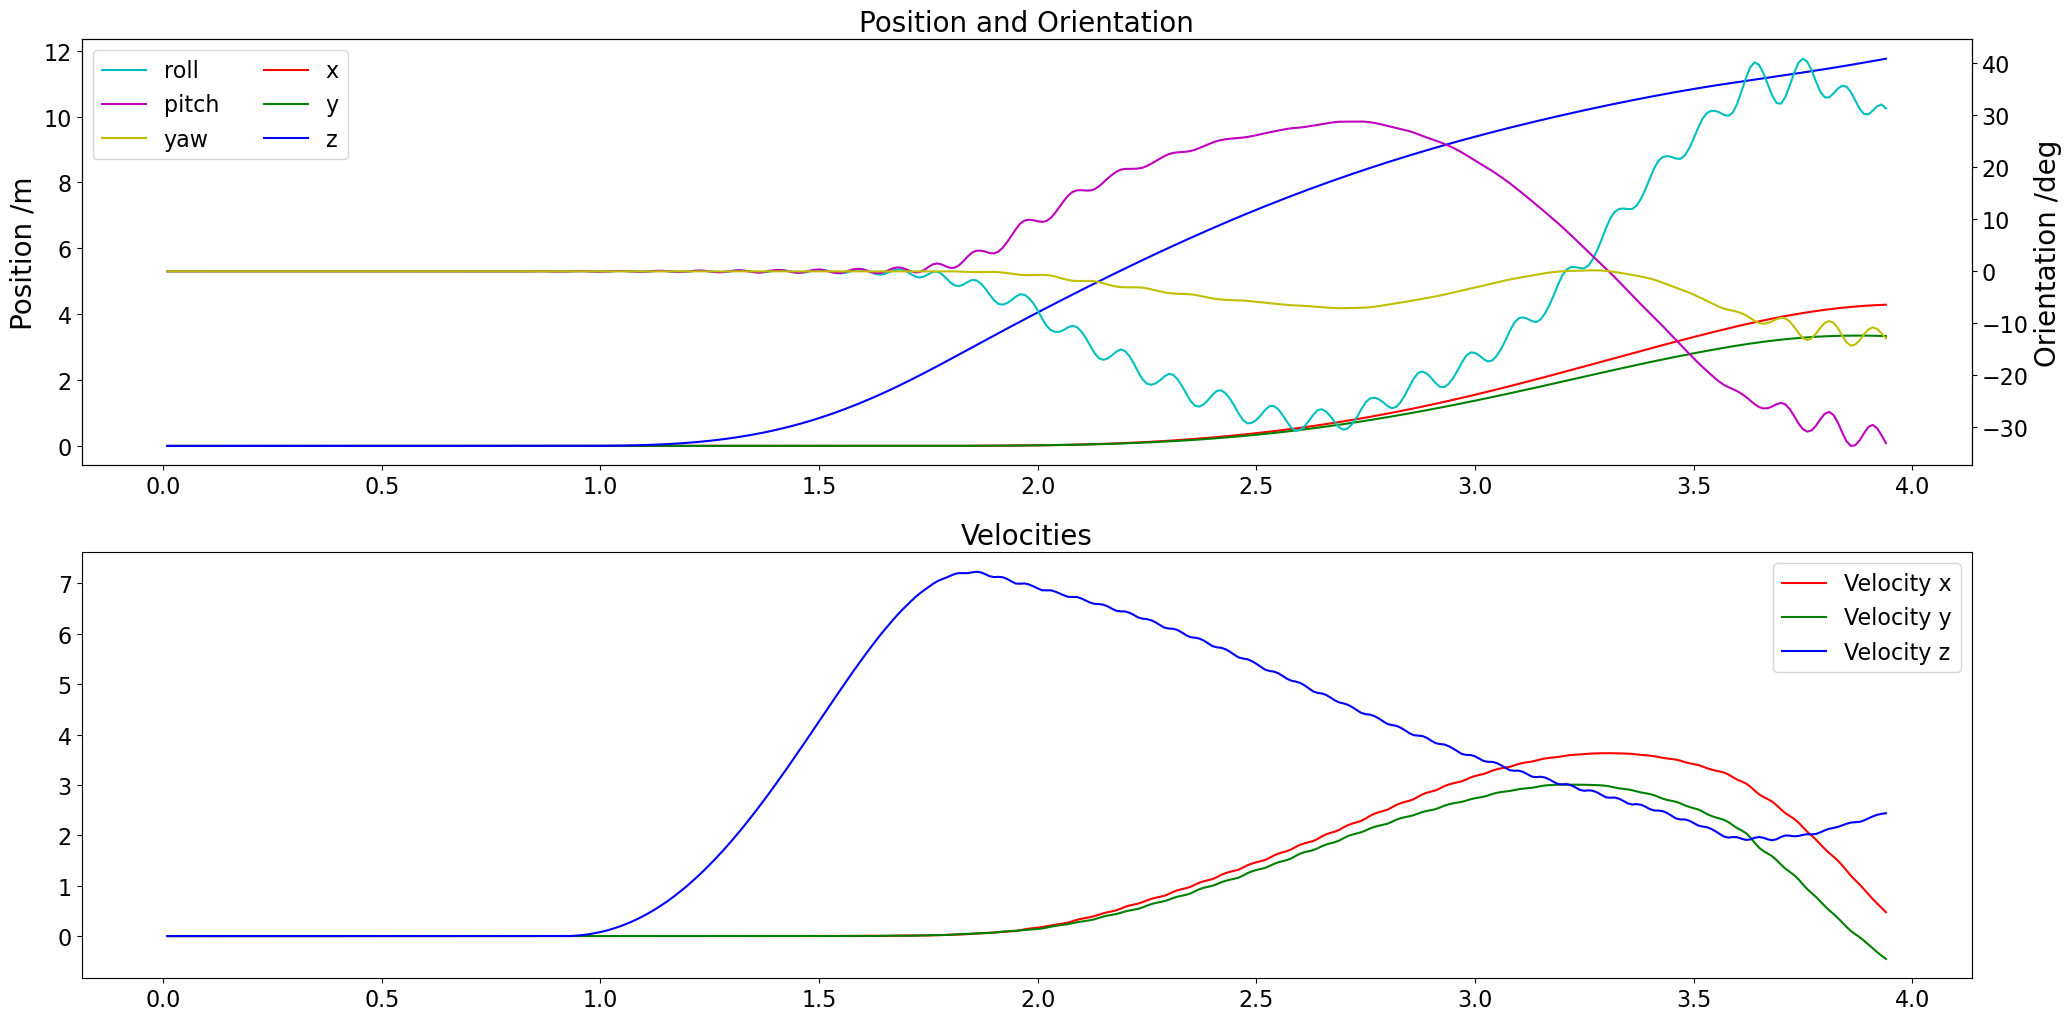

In [54]:
plot_datalog(ap_log, plots=('pos', 'vel'))

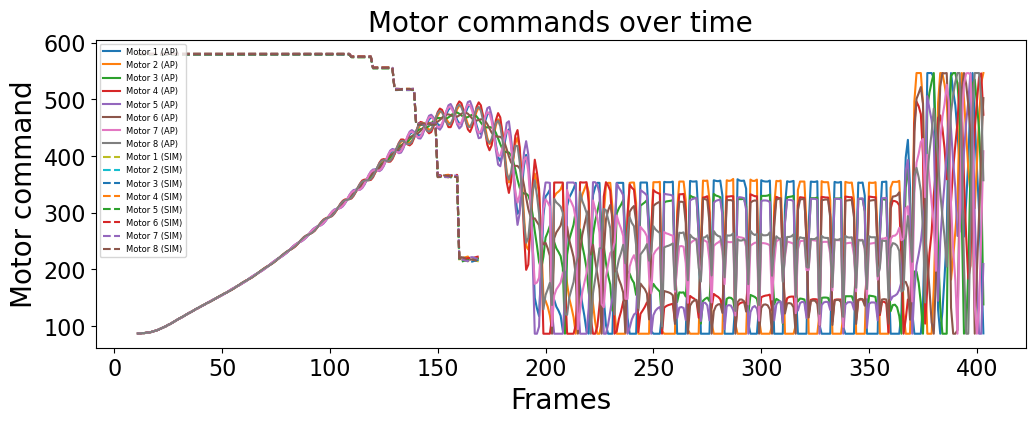

In [55]:
printLogNonZeroOverlay(action_log, sim_action_log, "Motor commands over time", start)

In [ ]:
printLogNonZero(action_log, "Change of AP signals over time")

In [ ]:
printLogNonZero(sim_action_log, "Change of SIM signals over time")

In [ ]:
printLog(action_log, "Change of AP signals over time")

In [ ]:
printLog(sim_action_log, "Change of SIM signals over time")